In [21]:
# Import Packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, GridSearchCV, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_curve, f1_score, auc, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
# Import Data
data = pd.read_csv("data/online_retail_II.csv")
print(data.columns)

Index(['Invoice', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'Price', 'Customer ID', 'Country'],
      dtype='object')


In [23]:
# STEP 1: Data Loading & Cleaning (To zostaje bez zmian)

# 1. Drop Duplicates & Trash
data = data.drop_duplicates()
trash_codes = [
    'POST', 'D', 'M', 'C2', 'BANK CHARGES', 
    'TEST001', 'TEST002', 'PADS', 'ADJUST', 
    'ADJUST2', 'SP1002', 'DOT', 'CRUK'
]
data = data[~data['StockCode'].isin(trash_codes)]

# 2. Clean Prices and Missing IDs
data = data[data['Price'] > 0]
data = data.dropna(subset=['Customer ID'])
data["InvoiceDate"] = pd.to_datetime(data["InvoiceDate"])

# 3. Handle Returns (Super ważne!)
# Twój kod tutaj jest bardzo dobry - oddziela sprzedaż od zwrotów
data['IsReturn'] = data['Invoice'].astype(str).str.startswith('C')
data['PurchaseAmount'] = np.where(data['IsReturn'] == False, data['Quantity'] * data['Price'], 0)
data['ReturnAmount'] = np.where(data['IsReturn'] == True,  (data['Quantity'] * data['Price']).abs(), 0)

# 4. Calculate True Net Revenue
data['NetRevenue'] = data['PurchaseAmount'] - data['ReturnAmount']

print("Data Cleaning Complete. Rows:", len(data))

Data Cleaning Complete. Rows: 794163


In [24]:
# STEP 2: Feature Engineering (Fixed: tx_dates order)

def generate_features_at_cutoff(df, cutoff_date, target_window_days=30):
    
    # Split data into history and future
    history = df[df['InvoiceDate'] <= cutoff_date].copy()
    future = df[(df['InvoiceDate'] > cutoff_date) & (df['InvoiceDate'] <= cutoff_date + pd.Timedelta(days=target_window_days))]
    
    snapshot_date = cutoff_date + pd.Timedelta(days=1)
    
    # 1. Base RFM (Lifetime)
    features = history.groupby('Customer ID').agg({
        'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
        'Invoice': 'nunique',
        'NetRevenue': 'sum',
        'StockCode': 'nunique'
    })
    features.columns = ['Recency', 'Frequency', 'Monetary', 'Unique_Products']
    
    # Tenure and Ratios
    first_purchase = history.groupby('Customer ID')['InvoiceDate'].min()
    features['Tenure'] = (snapshot_date - first_purchase).dt.days
    features['Avg_Ticket_Size'] = features['Monetary'] / features['Frequency']
    features['Product_Variety_Score'] = features['Unique_Products'] / features['Frequency']
    
    # 2. Trends (Deltas only)
    date_90  = cutoff_date - pd.Timedelta(days=90)
    date_180 = cutoff_date - pd.Timedelta(days=180)
    
    recent = history[history['InvoiceDate'] > date_90]
    prev   = history[(history['InvoiceDate'] <= date_90) & (history['InvoiceDate'] > date_180)]
    
    # Calculate Monetary Trend
    mon_recent = recent.groupby('Customer ID')['NetRevenue'].sum()
    mon_prev   = prev.groupby('Customer ID')['NetRevenue'].sum()
    
    features = features.join(mon_recent.rename('Mon_Recent'), how='left').fillna(0)
    features = features.join(mon_prev.rename('Mon_Prev'), how='left').fillna(0)
    features['Monetary_Trend'] = (features['Mon_Recent'] + 1) / (features['Mon_Prev'] + 1)
    
    # Calculate Frequency Trend
    freq_recent = recent.groupby('Customer ID')['Invoice'].nunique()
    freq_prev   = prev.groupby('Customer ID')['Invoice'].nunique()
    
    features = features.join(freq_recent.rename('Freq_Recent'), how='left').fillna(0)
    features = features.join(freq_prev.rename('Freq_Prev'), how='left').fillna(0)
    features['Frequency_Trend'] = (features['Freq_Recent'] + 1) / (features['Freq_Prev'] + 1)
    
    # Clean up temp columns
    features = features.drop(['Mon_Recent', 'Mon_Prev', 'Freq_Recent', 'Freq_Prev'], axis=1)

    # 3. Behavioral Extras
    returns = history[history['ReturnAmount'] > 0].groupby('Customer ID')['ReturnAmount'].count()
    total_tx = history.groupby('Customer ID')['Invoice'].count()
    features['Return_Rate'] = (returns / total_tx).fillna(0)
    
    country_map = history.groupby('Customer ID')['Country'].first()
    features['IsUK'] = (country_map == 'United Kingdom').astype(int)

    # 4. Latency & Consistency (Fixed Order Here!)
    # First: Create tx_dates
    tx_dates = history[['Customer ID', 'InvoiceDate']].drop_duplicates().sort_values(['Customer ID', 'InvoiceDate'])
    tx_dates['Prev_Date'] = tx_dates.groupby('Customer ID')['InvoiceDate'].shift(1)
    tx_dates['Days_Diff'] = (tx_dates['InvoiceDate'] - tx_dates['Prev_Date']).dt.days
    
    # Calculate Avg Gap
    avg_gap = tx_dates.groupby('Customer ID')['Days_Diff'].mean()
    features = features.join(avg_gap.rename('Avg_Gap'), how='left')
    features['Avg_Gap'] = features['Avg_Gap'].fillna(features['Recency'])
    
    # Calculate Gap Std (Consistency) - NOW IT WORKS
    gap_std = tx_dates.groupby('Customer ID')['Days_Diff'].std()
    features = features.join(gap_std.rename('Gap_Std'), how='left')
    
    # Fill NaN Std (for 1-time buyers) with 0 or a flag like -1. 
    # Using 0 assumes they are "stable" (no variation), which the model can interpret alongside Frequency=1
    features['Gap_Std'] = features['Gap_Std'].fillna(0) 
    
    # Calculate Risk
    features['Latency_Risk'] = features['Recency'] / (features['Avg_Gap'] + 1)
    
    # 5. Target
    buyers_in_future = future['Customer ID'].unique()
    features['Churn'] = (~features.index.isin(buyers_in_future)).astype(int)
    features['Cutoff_Date'] = cutoff_date
    
    return features.replace([np.inf, -np.inf], 0).fillna(0)

# Generate Panel Data
cutoffs = [
    pd.Timestamp('2011-01-01'),
    pd.Timestamp('2011-04-01'),
    pd.Timestamp('2011-07-01'),
    pd.Timestamp('2011-09-01')
]

print("Generating Optimized Panel Data...")
data_frames = []
for date in cutoffs:
    print(f"Processing snapshot: {date.date()}")
    df_snapshot = generate_features_at_cutoff(data, date, target_window_days=30)
    data_frames.append(df_snapshot)

full_panel_data = pd.concat(data_frames)
print(f"Panel Data Created. Shape: {full_panel_data.shape}")

Generating Optimized Panel Data...
Processing snapshot: 2011-01-01
Processing snapshot: 2011-04-01
Processing snapshot: 2011-07-01
Processing snapshot: 2011-09-01
Panel Data Created. Shape: (19350, 16)


In [25]:
# STEP 3: Time-Series Cross-Validation (Stability Check)

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# 1. FIX: Ensure Customer ID is a column, not an index
if 'Customer ID' not in full_panel_data.columns:
    full_panel_data = full_panel_data.reset_index()

# 2. Setup Params
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [6, 8, 10],
    'min_samples_leaf': [2, 4], # Ważne dla redukcji szumu
    'class_weight': ['balanced', 'balanced_subsample']
}

scores = []
print("Starting Time-Series Validation...")

# 3. Loop through dates (Expanding Window)
for i in range(1, len(cutoffs)):
    
    # A. Define Dates
    train_dates = cutoffs[:i]   # Past
    test_date = cutoffs[i]      # Current
    
    # B. Filter Data
    train_mask = full_panel_data['Cutoff_Date'].isin(train_dates)
    test_mask  = full_panel_data['Cutoff_Date'] == test_date
    
    # Prepare X/y (Drop metadata)
    X_train_curr = full_panel_data[train_mask].drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
    y_train_curr = full_panel_data.loc[train_mask, 'Churn']
    
    X_test_curr  = full_panel_data[test_mask].drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
    y_test_curr  = full_panel_data.loc[test_mask, 'Churn']
    
    # C. Inner Loop (GridSearch)
    clf = RandomForestClassifier(random_state=42, n_jobs=-1)
    grid = GridSearchCV(clf, param_grid, cv=3, scoring='f1', n_jobs=-1)
    grid.fit(X_train_curr, y_train_curr)
    
    # D. Evaluate
    best_model = grid.best_estimator_
    pred = best_model.predict(X_test_curr)
    score = f1_score(y_test_curr, pred)
    scores.append(score)
    
    print(f"Test Date: {test_date.date()} | Train size: {len(X_train_curr)} | F1-Score: {score:.2%}")

print("-" * 40)
print(f"Average Stability Score (F1): {np.mean(scores):.2%}")
print("-" * 40)

Starting Time-Series Validation...
Test Date: 2011-04-01 | Train size: 4344 | F1-Score: 90.00%
Test Date: 2011-07-01 | Train size: 9062 | F1-Score: 90.01%
Test Date: 2011-09-01 | Train size: 14102 | F1-Score: 88.23%
----------------------------------------
Average Stability Score (F1): 89.41%
----------------------------------------


In [26]:
# STEP 4: Final Model Training

# 1. Prepare Full Data
# Train on ALL available history
print("Training Final Model on full dataset...")
X_final = full_panel_data.drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
y_final = full_panel_data['Churn']

# 2. Fit Model
# Using best params found manually or via GridSearch
final_model = RandomForestClassifier(n_estimators=200, max_depth=8, class_weight='balanced', random_state=42)
final_model.fit(X_final, y_final)

print("✅ Final Model Trained & Ready.")

Training Final Model on full dataset...
✅ Final Model Trained & Ready.


Generating Out-of-Time Test Set for: 2011-11-01...
----------------------------------------
Out-of-Time Accuracy: 75.94%
Out-of-Time F1 Score: 83.23%
----------------------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.61      0.57      1514
           1       0.85      0.82      0.83      4142

    accuracy                           0.76      5656
   macro avg       0.70      0.71      0.70      5656
weighted avg       0.77      0.76      0.76      5656



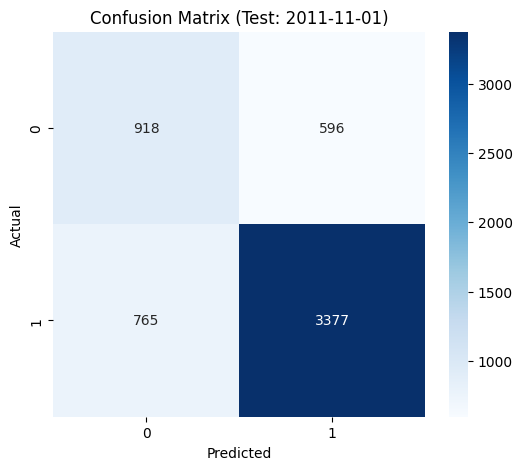

In [27]:
# STEP 5: Out-of-Time Evaluation (Production Simulation)

from sklearn.metrics import accuracy_score, confusion_matrix

# 1. Generate Test Data for a Future Date (Out-of-Time)
# We use Nov 1st, 2011. Note: Target window is shorter (30 days) as data ends in Dec.
test_date = pd.Timestamp('2011-11-01')
print(f"Generating Out-of-Time Test Set for: {test_date.date()}...")

test_df = generate_features_at_cutoff(data, test_date, target_window_days=30)

# FIX: Reset index so 'Customer ID' becomes a column we can drop
test_df = test_df.reset_index()

# 2. Prepare X_test and y_test
# Now 'Customer ID' exists as a column, so this drop will work
X_test = test_df.drop(['Churn', 'Customer ID', 'Cutoff_Date'], axis=1)
y_test = test_df['Churn']

# Clean Infinite values (same as training)
X_test = X_test.replace([np.inf, -np.inf], 0).fillna(0)

# 3. Predict using Final Model
y_pred = final_model.predict(X_test)
y_prob = final_model.predict_proba(X_test)[:, 1]

# 4. Evaluation Metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("-" * 40)
print(f"Out-of-Time Accuracy: {accuracy:.2%}")
print(f"Out-of-Time F1 Score: {f1:.2%}")
print("-" * 40)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# 5. Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix (Test: {test_date.date()})')
plt.show()

--- ADVANCED METRICS ANALYSIS ---



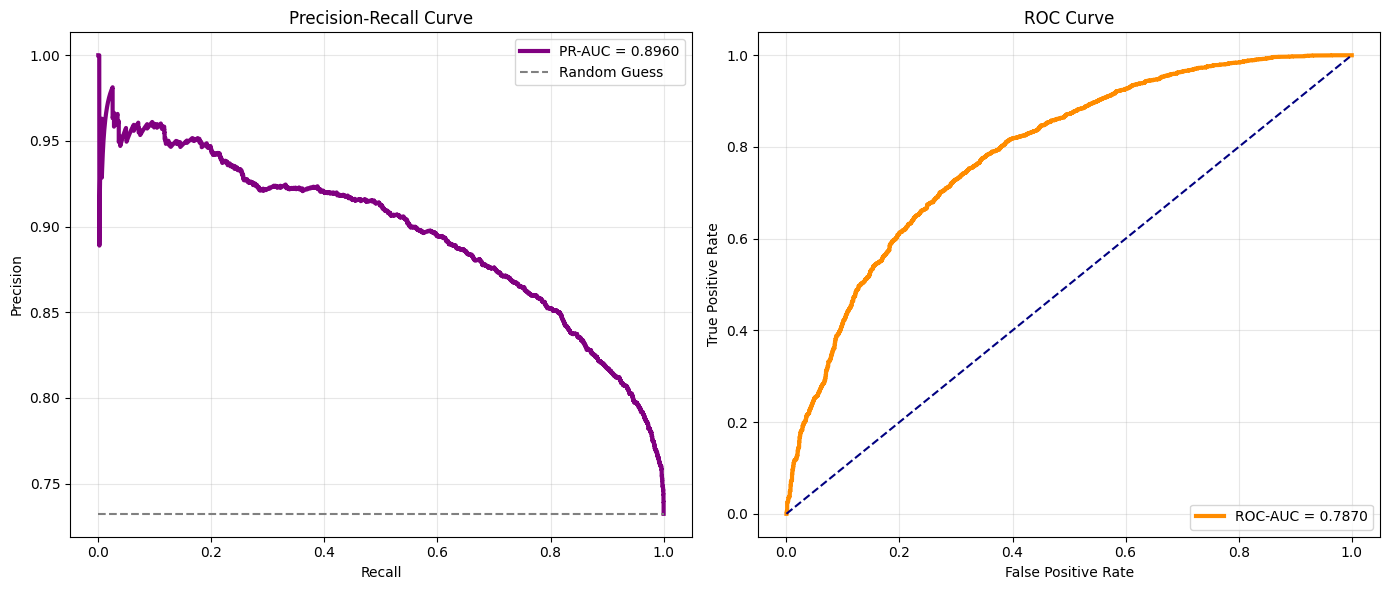

✅ Final PR-AUC: 0.8960 
✅ Final ROC-AUC: 0.7870
----------------------------------------


In [32]:
# STEP 5b: Advanced Model Evaluation (PR-AUC & ROC-AUC)

print("--- ADVANCED METRICS ANALYSIS ---\n")

# 1. Get Probabilities
y_probs = final_model.predict_proba(X_test)[:, 1]

# 2. Calculate Precision-Recall Curve (Crucial for Imbalanced Data)
precision, recall, _ = precision_recall_curve(y_test, y_probs)
pr_auc = auc(recall, precision)

# 3. Calculate ROC Curve (Standard Metric)
fpr, tpr, _ = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# 4. Plotting
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot PR Curve
ax1.plot(recall, precision, label=f'PR-AUC = {pr_auc:.4f}', color='purple', linewidth=3)
ax1.plot([0, 1], [y_test.mean(), y_test.mean()], linestyle='--', label='Random Guess', color='gray')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')
ax1.legend(loc='best')
ax1.grid(True, alpha=0.3)

# Plot ROC Curve
ax2.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.4f}', color='darkorange', linewidth=3)
ax2.plot([0, 1], [0, 1], linestyle='--', color='navy')
ax2.set_xlabel('False Positive Rate')
ax2.set_ylabel('True Positive Rate')
ax2.set_title('ROC Curve')
ax2.legend(loc='lower right')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Final PR-AUC: {pr_auc:.4f} ")
print(f"✅ Final ROC-AUC: {roc_auc:.4f}")
print("-" * 40)

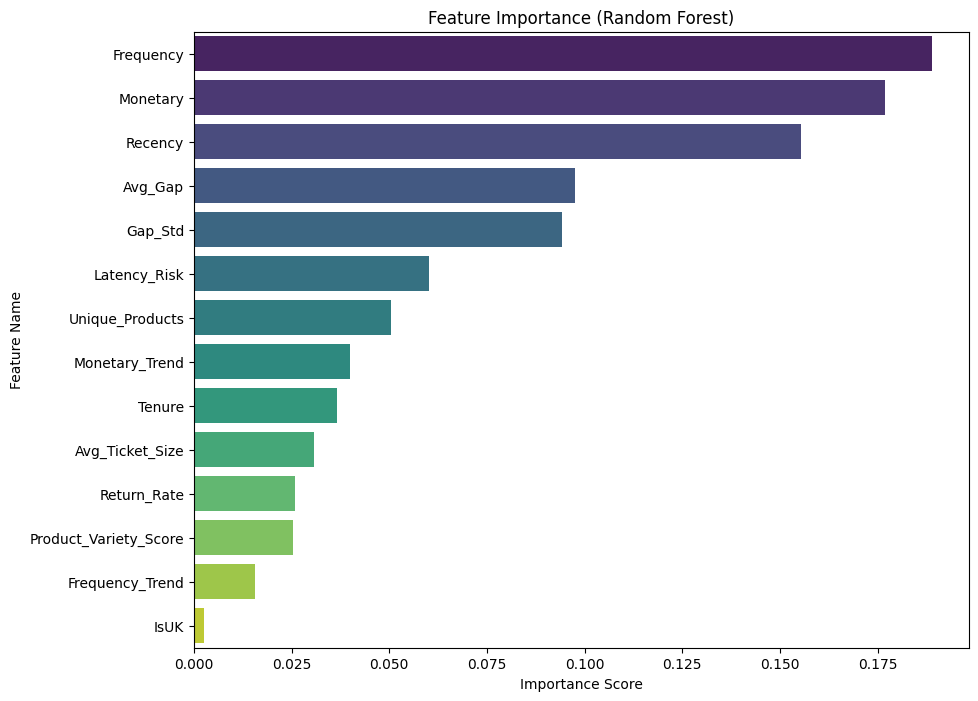


--- FEATURE IMPORTANCE RANKING ---
                  Feature  Importance
1               Frequency    0.188943
2                Monetary    0.176907
0                 Recency    0.155291
11                Avg_Gap    0.097501
12                Gap_Std    0.094104
13           Latency_Risk    0.060197
3         Unique_Products    0.050479
7          Monetary_Trend    0.040001
4                  Tenure    0.036657
5         Avg_Ticket_Size    0.030722
9             Return_Rate    0.025863
6   Product_Variety_Score    0.025277
8         Frequency_Trend    0.015523
10                   IsUK    0.002536


In [29]:
# STEP 6: Feature Importance Analysis (Fixed for Seaborn warning)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Get Importances from the trained model
# Using 'final_model' from Step 4
importances = final_model.feature_importances_

# 2. Get Feature Names
# Using X_test columns to match features
feature_names = X_test.columns

# 3. Create a Summary Table
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 4. Plot the Results
plt.figure(figsize=(10, 8))

# FIX: Added hue='Feature' and legend=False to silence the FutureWarning
sns.barplot(
    x='Importance', 
    y='Feature', 
    hue='Feature',       # Explicitly map color to Feature
    data=feature_importance_df, 
    palette='viridis', 
    legend=False         # Hide the redundant legend
)

plt.xlabel('Importance Score')
plt.ylabel('Feature Name')
plt.title('Feature Importance (Random Forest)')
plt.show()

# 5. Print the Ranking
print("\n--- FEATURE IMPORTANCE RANKING ---")
print(feature_importance_df)

In [30]:
# STEP 7: Segmentation with Fixed Business Rules (Hardcoded)

# 1. Get probabilities from the model
churn_probs = final_model.predict_proba(X_test)[:, 1]

# 2. Create Results Table
results = pd.DataFrame({
    'Actual_Status': y_test.values,
    'Churn_Risk': churn_probs
})
# Restore Customer ID as index (Crucial for Step 8)
results.index = test_df['Customer ID']

# 3. Define Segments based on Rigid Rules
# We use fixed probabilities instead of dynamic thresholds.
# These can be adjusted based on marketing capacity.
def get_segment_fixed(prob):
    # Rule 1: >80% is almost certainly churn (or already left)
    if prob >= 0.80:
        return '🔴 Critical'
    
    # Rule 2: 60-80% is our sweet spot for intervention
    elif prob >= 0.60:
        return '🟠 At Risk'
    
    # Rule 3: 40-60% is uncertain, keep an eye on them
    elif prob >= 0.40:
        return '🟡 Watchlist'
    
    # Rule 4: <40% is safe
    else:
        return '🟢 Safe'

results['Segment'] = results['Churn_Risk'].apply(get_segment_fixed)

# 4. Summary
print("\n--- FIXED SEGMENTATION SUMMARY ---")
print(results['Segment'].value_counts())

# 5. Top Candidates for Action
# We focus on the 'At Risk' group (60-80%) or Critical (>80%) depending on strategy
action_group = results[results['Segment'].isin(['🟠 At Risk', '🔴 Critical'])]
action_group = action_group.sort_values('Churn_Risk', ascending=False)

print(f"\n--- Customers requiring attention: {len(action_group)} ---")
if not action_group.empty:
    display(action_group.head(10))


--- FIXED SEGMENTATION SUMMARY ---
Segment
🔴 Critical     1701
🟠 At Risk      1628
🟡 Watchlist    1172
🟢 Safe         1155
Name: count, dtype: int64

--- Customers requiring attention: 3329 ---


,Actual_Status,Churn_Risk,Segment
Customer ID,,,
17626.0,1,0.963698,🔴 Critical
15474.0,1,0.963156,🔴 Critical
14391.0,1,0.963060,🔴 Critical
14325.0,1,0.962743,🔴 Critical
14588.0,1,0.962709,🔴 Critical
14787.0,1,0.962199,🔴 Critical
12595.0,1,0.962161,🔴 Critical
13943.0,1,0.962129,🔴 Critical
15597.0,0,0.962129,🔴 Critical


In [31]:
# STEP 8: Financial Impact Analysis (Fixed Logic)

# 1. Prepare Financial Data
# We use 'test_df' from Step 5 to get raw Monetary/Tenure values
# aligning them with our prediction results
X_test_financial = test_df.set_index('Customer ID').loc[results.index].copy()

# 2. Calculate Annual Potential (Safe Extrapolation)
# Base calculation: Average Daily Spend * 365
daily_spend = X_test_financial['Monetary'] / (X_test_financial['Tenure'] + 1)
projected_annual = daily_spend * 365

# CRITICAL FIX: Cap unrealistic projections for new customers.
# Rule: Never assume potential > 3x of what they actually spent so far.
# This prevents inflating value for 1-day tenure customers.
X_test_financial['Annual_Potential'] = np.minimum(projected_annual, X_test_financial['Monetary'] * 3)

# 3. Merge with Segmentation Results
financial_report = results.join(X_test_financial[['Annual_Potential']], how='left')

# 4. Group by Segment
risk_report = financial_report.groupby('Segment')['Annual_Potential'].sum().sort_values(ascending=False)

# 5. Print Business Report
print("-" * 50)
print("💰 ESTIMATED ANNUAL REVENUE AT RISK (Nov 2011)")
print("-" * 50)

for segment, amount in risk_report.items():
    print(f"{segment.ljust(35)} : £ {amount:,.2f}")

print("-" * 50)

# Calculate Total "At Risk" Value
# Summing up High Risk and Priority segments
total_risk_val = risk_report.get('🟠 At Risk', 0) + \
                 risk_report.get('🔴 Critical', 0)

print(f"Total Revenue requiring immediate protection: £ {total_risk_val:,.2f}")
print("-" * 50)

--------------------------------------------------
💰 ESTIMATED ANNUAL REVENUE AT RISK (Nov 2011)
--------------------------------------------------
🟢 Safe                              : £ 6,643,705.48
🟡 Watchlist                         : £ 1,860,839.95
🟠 At Risk                           : £ 1,380,856.81
🔴 Critical                          : £ 768,003.59
--------------------------------------------------
Total Revenue requiring immediate protection: £ 2,148,860.40
--------------------------------------------------
